# 06: Evaluate LLMs for Systematic Review Screening (v2 - Improved)

## Objective
Evaluate whether LLMs can correctly determine if a paper should be **included** or **excluded** from a Cochrane systematic review.

## Improvements in v2
- **Temperature = 0.2** for all models (more deterministic outputs)
- **Few-shot prompting** with 3 examples to calibrate model behavior
- **Improved prompts** with explicit PICOS criteria and "when uncertain, INCLUDE" guidance
- **Larger models** including DeepSeek-R1 32B, Qwen 2.5 32B, Llama 3.3 70B

## Task
Given:
- **Review context** (title + abstract of the Cochrane review - defines the screening criteria)
- **Paper abstract** (the candidate study being screened)

Predict: INCLUDE or EXCLUDE

## Dataset
- **Validation set**: `ground_truth_validation_dataset.csv` - All Cochrane groups
- **Evaluation subset**: Public Health group only (4,089 records) - domain-relevant to UKHSA

## Prompt Types
1. **Zero-shot** - Direct question with few-shot examples
2. **Chain-of-thought (CoT)** - Step-by-step PICOS analysis before deciding

## Models (13 Models - All Local via Ollama)

### Large Models (NEW - RTX 5090)
| Model | Size | Description |
|-------|------|-------------|
| **DeepSeek-R1 32B** | 32B | State-of-the-art reasoning model |
| **Qwen 2.5 32B** | 32B | Top open-source model, rivals GPT-4 |
| **Llama 3.3 70B** | 70B (Q4) | Largest Llama, quantized to fit |

### General-Purpose Models
| Model | Size | Description |
|-------|------|-------------|
| **Llama 3.2** | 3B | Meta's efficient baseline model |
| **Llama 3.1 8B** | 8B | Stronger instruction-following |
| **Mistral 7B** | 7B | Strong general-purpose model |
| **Mixtral 8x7B** | 46.7B (MOE) | Mixture of Experts, very powerful |
| **Qwen 2.5 14B** | 14B | Top benchmarks at this size |
| **Gemma 2 9B** | 9B | Google's latest, excellent classification |
| **Phi-3 Medium** | 14B | Microsoft's efficient model |

### Biomedical-Specialized Models
| Model | Size | Description |
|-------|------|-------------|
| **OpenBioLLM-8B** | 8B | Llama-3 fine-tuned, outperforms GPT-3.5 on medical |
| **BioMistral 7B** | 7B | Mistral fine-tuned on PubMed Central |
| **Meditron 7B** | 7B | Fine-tuned on medical guidelines & PubMed |

## Configuration
- **Temperature**: 0.2 (lower = more deterministic)
- **Few-shot examples**: 3 (INCLUDE and EXCLUDE examples)
- **Max tokens**: 2048 (for CoT reasoning)

## Output
- `Data/results/eval_*.csv` - Predictions with LLM reasoning saved
- Metrics: Accuracy, Precision, Recall, F1, Specificity

**IMPORTANT:** All inference is local via Ollama - no data sent to external APIs.

In [19]:
# Install required packages for local LLM inference
%pip install -q ollama pandas scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Setup and load data
import os
from pathlib import Path
import pandas as pd
import ollama
from tqdm.notebook import tqdm
from datetime import datetime
import time

notebook_dir = Path.cwd()
project_root = notebook_dir if (notebook_dir / "Data").exists() else notebook_dir.parent
DATA_DIR = project_root / "Data"
RESULTS_DIR = DATA_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

GROUND_TRUTH_CSV = DATA_DIR / "ground_truth_validation_dataset.csv"

# Load validation set (all Cochrane groups, filterable by cochrane_group column)
ground_truth = pd.read_csv(GROUND_TRUTH_CSV)
print(f"Loaded validation set: {len(ground_truth):,} examples")
print(f"\nLabel distribution:")
print(f"  Included: {(ground_truth['label'] == 1).sum():,}")
print(f"  Excluded: {(ground_truth['label'] == 0).sum():,}")
print(f"\nUnique reviews: {ground_truth['review_doi'].nunique():,}")
print(f"\nCochrane groups available (filter with cochrane_group column):")
print(ground_truth['cochrane_group'].value_counts().to_string())

Loaded validation set: 41,692 examples

Label distribution:
  Included: 14,738
  Excluded: 26,954

Unique reviews: 1,228

Cochrane groups available (filter with cochrane_group column):
cochrane_group
Acute Respiratory Infections    11455
Tobacco Addiction               10198
Infectious Diseases              8516
Drugs and Alcohol                6754
Public Health                    4089
STI                               680


In [21]:
# Check available Ollama models
try:
    models = ollama.list()
    print("Available local models:")
    if hasattr(models, 'models'):
        for model in models.models:
            name = model.model if hasattr(model, 'model') else str(model)
            print(f"  - {name}")
    elif isinstance(models, dict) and 'models' in models:
        for model in models['models']:
            name = model.get('name', model.get('model', str(model)))
            print(f"  - {name}")
    else:
        print(f"  Models: {models}")
except Exception as e:
    print(f"Error connecting to Ollama: {e}")
    print("Make sure Ollama is running: ollama serve")

Available local models:
  - qwen2.5:32b
  - deepseek-r1:32b
  - mixtral:latest
  - qwen2.5:14b
  - mistral-nemo:12b
  - meditron:7b
  - phi3:medium
  - gemma2:9b
  - qwen2.5:7b
  - llama3.1:8b
  - cniongolo/biomistral:latest
  - koesn/llama3-openbiollm-8b:latest
  - mistral:latest
  - llama3.2:latest


In [40]:
# =============================================================================
# CALIBRATED Prompt Templates v3 - Stronger Exclusion Bias Correction
# =============================================================================
# 
# KEY CHANGES from v2:
# 1. Explicit base rate: "Only ~20% should be INCLUDE"
# 2. Default to EXCLUDE unless ALL criteria clearly match
# 3. Stronger emphasis on specificity (excluding irrelevant papers)
# 4. Cost framing: false positives waste reviewer time
# =============================================================================

# Few-shot examples - 3 EXCLUDE, 2 INCLUDE (matching real base rate ~20% include)
FEW_SHOT_EXAMPLES = """
=== EXAMPLE 1: EXCLUDE ===
REVIEW: "Interventions for preventing obesity in children"
PAPER: "Body mass index trajectories from childhood to adulthood: a longitudinal cohort study"
DECISION: EXCLUDE
REASON: This is an OBSERVATIONAL cohort study tracking BMI over time. The review requires INTERVENTION trials. No intervention = EXCLUDE.

=== EXAMPLE 2: EXCLUDE ===
REVIEW: "School-based physical activity programs for children"
PAPER: "Effectiveness of workplace exercise programs for reducing sedentary time in office workers"
DECISION: EXCLUDE
REASON: WRONG POPULATION (adults, not children) and WRONG SETTING (workplace, not school). Population mismatch = EXCLUDE.

=== EXAMPLE 3: EXCLUDE ===
REVIEW: "Interventions for preventing obesity in children"
PAPER: "Prevalence of childhood obesity in rural versus urban areas: cross-sectional survey"
DECISION: EXCLUDE
REASON: This is a PREVALENCE SURVEY (descriptive epidemiology). No intervention is being tested. Descriptive study = EXCLUDE.

=== EXAMPLE 4: INCLUDE ===
REVIEW: "Interventions for preventing obesity in children"
PAPER: "A school-based nutrition education program to reduce obesity risk in children: randomized controlled trial"
DECISION: INCLUDE
REASON: INTERVENTION study (nutrition education program), correct POPULATION (children), correct OUTCOME (obesity prevention), RCT design. All criteria match = INCLUDE.

=== EXAMPLE 5: INCLUDE ===
REVIEW: "School-based physical activity programs for children"
PAPER: "Impact of daily physical education classes on fitness levels in elementary school students: cluster randomized trial"
DECISION: INCLUDE  
REASON: INTERVENTION (daily PE classes), correct POPULATION (elementary school children), correct SETTING (school-based), trial design. All criteria match = INCLUDE.
"""

# CALIBRATED Zero-shot prompt - DEFAULT IS EXCLUDE
ZERO_SHOT_PROMPT = """You are screening papers for a Cochrane systematic review. Your job is to EXCLUDE papers that don't match.

CRITICAL CALIBRATION:
- In this dataset, only ~20% of papers should be INCLUDED
- Most papers (~80%) should be EXCLUDED
- If in doubt, EXCLUDE - false positives waste reviewer time

EXCLUSION CRITERIA (if ANY apply → EXCLUDE):
1. WRONG POPULATION - Paper studies different population than the review targets
2. WRONG INTERVENTION - Paper doesn't evaluate the intervention/exposure the review examines
3. WRONG STUDY DESIGN - Paper is observational/descriptive when review needs trials
4. WRONG TOPIC - Paper addresses a tangentially related but different question

INCLUSION CRITERIA (ALL must apply → INCLUDE):
✓ Population matches the review's target population
✓ Intervention/exposure matches what the review examines
✓ Study design is appropriate (usually trials for Cochrane reviews)
✓ Outcomes are relevant to the review question

{few_shot}

=== REVIEW BEING CONDUCTED ===
Title: {review_title}

Criteria: {review_abstract}

=== PAPER TO SCREEN ===
Title: {paper_title}

Abstract: {paper_abstract}

=== YOUR DECISION ===
Does this paper match ALL inclusion criteria? Most papers do NOT.

Respond with exactly one word: INCLUDE or EXCLUDE"""


# CALIBRATED CoT prompt - Structured exclusion-first analysis
COT_PROMPT = """You are screening papers for a Cochrane systematic review. Your job is to EXCLUDE papers that don't match.

CRITICAL CALIBRATION:
- In this dataset, only ~20% of papers should be INCLUDED
- Most papers (~80%) should be EXCLUDED  
- If in doubt, EXCLUDE - false positives waste reviewer time

EXCLUSION CHECKLIST (if ANY = NO → EXCLUDE):
□ Population match? Paper studies the same population as the review?
□ Intervention match? Paper evaluates the intervention/exposure the review examines?
□ Study design match? Paper is the right type (trials for most Cochrane reviews)?

{few_shot}

=== REVIEW BEING CONDUCTED ===
Title: {review_title}

Criteria: {review_abstract}

=== PAPER TO SCREEN ===
Title: {paper_title}

Abstract: {paper_abstract}

=== EXCLUSION-FIRST ANALYSIS ===

Step 1 - POPULATION CHECK:
- Review targets: [identify the population]
- Paper studies: [identify the population]  
- Match? [YES/NO] - If NO → EXCLUDE

Step 2 - INTERVENTION CHECK:
- Review examines: [identify intervention/exposure]
- Paper examines: [identify what the paper studies]
- Match? [YES/NO] - If NO → EXCLUDE

Step 3 - STUDY DESIGN CHECK:
- Review requires: [usually RCTs or intervention trials]
- Paper design: [identify: RCT, cohort, cross-sectional, survey, review, etc.]
- Match? [YES/NO] - If observational when trials needed → EXCLUDE

Step 4 - FINAL DECISION:
- If ANY check = NO → EXCLUDE
- If ALL checks = YES → INCLUDE

DECISION: [INCLUDE or EXCLUDE]"""


def create_prompt(row: pd.Series, use_cot: bool = False, include_few_shot: bool = True) -> str:
    """Create prompt with review context, paper abstract, and optional few-shot examples."""
    template = COT_PROMPT if use_cot else ZERO_SHOT_PROMPT
    few_shot = FEW_SHOT_EXAMPLES if include_few_shot else ""
    
    return template.format(
        few_shot=few_shot,
        review_title=str(row['review_title'])[:500],
        review_abstract=str(row['review_abstract'])[:2000],
        paper_title=str(row['paper_title'])[:300],
        paper_abstract=str(row['paper_abstract'])[:2000]
    )

# Preview the new prompt
sample = ground_truth.iloc[0]
print("=" * 80)
print("CALIBRATED v3 ZERO-SHOT PROMPT (stronger exclusion bias):")
print("=" * 80)
print(create_prompt(sample, use_cot=False)[:3000] + "\n...[truncated]...")
print("\n" + "=" * 80)
print("KEY CHANGES:")
print("  1. Explicit '~20% should be INCLUDE' calibration")
print("  2. 'If in doubt, EXCLUDE' (previously was 'if uncertain, INCLUDE')")
print("  3. Few-shot examples: 3 EXCLUDE + 2 INCLUDE (was more balanced)")
print("  4. Exclusion-first framing: check for reasons to EXCLUDE")
print("=" * 80)

CALIBRATED v3 ZERO-SHOT PROMPT (stronger exclusion bias):
You are screening papers for a Cochrane systematic review. Your job is to EXCLUDE papers that don't match.

CRITICAL CALIBRATION:
- In this dataset, only ~20% of papers should be INCLUDED
- Most papers (~80%) should be EXCLUDED
- If in doubt, EXCLUDE - false positives waste reviewer time

EXCLUSION CRITERIA (if ANY apply → EXCLUDE):
1. WRONG POPULATION - Paper studies different population than the review targets
2. WRONG INTERVENTION - Paper doesn't evaluate the intervention/exposure the review examines
3. WRONG STUDY DESIGN - Paper is observational/descriptive when review needs trials
4. WRONG TOPIC - Paper addresses a tangentially related but different question

INCLUSION CRITERIA (ALL must apply → INCLUDE):
✓ Population matches the review's target population
✓ Intervention/exposure matches what the review examines
✓ Study design is appropriate (usually trials for Cochrane reviews)
✓ Outcomes are relevant to the review questio

In [23]:
# =============================================================================
# Evaluation Functions - With Temperature Control
# =============================================================================
import re

# Global temperature setting for all models
TEMPERATURE = 0.2  # Lower = more deterministic, better for classification

def extract_decision(response: str) -> int:
    """Extract INCLUDE (1) or EXCLUDE (0) from LLM response."""
    response_upper = response.upper()
    
    # Look for explicit DECISION: pattern first (CoT)
    decision_match = re.search(r'DECISION:\s*(INCLUDE|EXCLUDE)', response_upper)
    if decision_match:
        return 1 if decision_match.group(1) == 'INCLUDE' else 0
    
    # Look for standalone INCLUDE/EXCLUDE at end of response
    lines = response_upper.strip().split('\n')
    for line in reversed(lines[-5:]):  # Check last 5 lines
        line = line.strip()
        if line == 'INCLUDE':
            return 1
        if line == 'EXCLUDE':
            return 0
    
    # Fall back to last occurrence
    include_pos = response_upper.rfind('INCLUDE')
    exclude_pos = response_upper.rfind('EXCLUDE')
    
    if include_pos > exclude_pos:
        return 1
    elif exclude_pos > include_pos:
        return 0
    
    return -1  # Could not determine


def run_evaluation(model_name: str, data: pd.DataFrame, use_cot: bool = False, 
                   temperature: float = TEMPERATURE) -> pd.DataFrame:
    """Run evaluation with temperature control and save full LLM reasoning."""
    results = []
    prompt_type = 'cot' if use_cot else 'zero_shot'
    
    print(f"Using temperature={temperature} for {model_name}")
    
    for idx, row in tqdm(data.iterrows(), total=len(data), desc=f"{model_name} ({prompt_type})"):
        prompt = create_prompt(row, use_cot=use_cot)
        
        try:
            start = time.time()
            response = ollama.generate(
                model=model_name, 
                prompt=prompt,
                options={
                    'temperature': temperature,
                    'num_predict': 2048,  # Max tokens for CoT reasoning
                }
            )
            elapsed = time.time() - start
            response_text = response.get('response', '')
            prediction = extract_decision(response_text)
        except Exception as e:
            response_text = f"ERROR: {e}"
            prediction = -1
            elapsed = 0
        
        results.append({
            'review_doi': row['review_doi'],
            'study_id': row['study_id'],
            'label': row['label'],
            'prediction': prediction,
            'correct': prediction == row['label'],
            'reasoning': response_text,
            'response_time_sec': round(elapsed, 2),
            'temperature': temperature
        })
    
    return pd.DataFrame(results)


print(f"Evaluation functions defined. Temperature set to {TEMPERATURE}")

Evaluation functions defined. Temperature set to 0.2


In [24]:
# =============================================================================
# Setup: Define eval_data and all_results
# =============================================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Filter to Public Health Cochrane group only (4,089 records)
eval_data = ground_truth[ground_truth['cochrane_group'] == 'Public Health'].copy()

print(f"Evaluation dataset: {len(eval_data):,} Public Health samples")
print(f"  Included: {(eval_data['label'] == 1).sum():,} ({(eval_data['label'] == 1).mean()*100:.1f}%)")
print(f"  Excluded: {(eval_data['label'] == 0).sum():,} ({(eval_data['label'] == 0).mean()*100:.1f}%)")

# Dictionary to store all results (will be populated by evaluation cells)
all_results = {}
print("\n✓ eval_data and all_results initialized. Run individual evaluation cells below.")

Evaluation dataset: 4,089 Public Health samples
  Included: 848 (20.7%)
  Excluded: 3,241 (79.3%)

✓ eval_data and all_results initialized. Run individual evaluation cells below.


In [42]:
# =============================================================================
# QUICK VALIDATION: Test new prompts on 50 samples before full evaluation
# =============================================================================
# This runs a fast sanity check to see if the prompts are working better
# before committing to a full 4,089-sample evaluation run.

TEST_MODEL = "mixtral"  # Use the same model that had issues
TEST_SIZE = 50  # Small sample for quick validation

# Sample stratified by label to get representative mix
test_include = eval_data[eval_data['label'] == 1].sample(n=min(10, (eval_data['label']==1).sum()), random_state=42)
test_exclude = eval_data[eval_data['label'] == 0].sample(n=min(40, (eval_data['label']==0).sum()), random_state=42)
test_data = pd.concat([test_include, test_exclude]).sample(frac=1, random_state=42)

print(f"Quick validation: {len(test_data)} samples ({(test_data['label']==1).sum()} INCLUDE, {(test_data['label']==0).sum()} EXCLUDE)")
print(f"Testing model: {TEST_MODEL}")
print(f"Expected: INCLUDE predictions should be ~20%, not 60%+")
print("-" * 60)

# Run quick test
test_results = run_evaluation(TEST_MODEL, test_data, use_cot=False)
valid = test_results[test_results['prediction'] != -1]

# Analyze results
pred_include_rate = (valid['prediction'] == 1).mean() * 100
cm = confusion_matrix(valid['label'], valid['prediction'])
tn, fp, fn, tp = cm.ravel()

print(f"\n{'='*60}")
print(f"QUICK VALIDATION RESULTS ({TEST_MODEL} zero-shot, n={len(valid)})")
print(f"{'='*60}")
print(f"Predicted INCLUDE: {(valid['prediction']==1).sum()}/{len(valid)} ({pred_include_rate:.1f}%)")
print(f"Predicted EXCLUDE: {(valid['prediction']==0).sum()}/{len(valid)} ({100-pred_include_rate:.1f}%)")
print(f"\nConfusion Matrix:")
print(f"  TN (correct EXCLUDE): {tn}")
print(f"  FP (wrong INCLUDE):   {fp}")
print(f"  FN (wrong EXCLUDE):   {fn}")
print(f"  TP (correct INCLUDE): {tp}")
print(f"\nMetrics:")
print(f"  Accuracy:    {accuracy_score(valid['label'], valid['prediction']):.3f}")
print(f"  Precision:   {precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}")
print(f"  Recall:      {recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}")
print(f"  F1 Score:    {f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")
print(f"  Specificity: {tn/(tn+fp) if (tn+fp)>0 else 0:.3f}")

if pred_include_rate < 40:
    print(f"\n✓ GOOD: Model is now more balanced ({pred_include_rate:.1f}% INCLUDE)")
    print("  → Safe to run full evaluation")
elif pred_include_rate < 60:
    print(f"\n⚠ MODERATE: Still somewhat over-inclusive ({pred_include_rate:.1f}% INCLUDE)")
    print("  → Consider further prompt adjustments, or proceed with caution")
else:
    print(f"\n✗ BAD: Still severely over-inclusive ({pred_include_rate:.1f}% INCLUDE)")
    print("  → Prompts need more work before full evaluation")

Quick validation: 50 samples (10 INCLUDE, 40 EXCLUDE)
Testing model: mixtral
Expected: INCLUDE predictions should be ~20%, not 60%+
------------------------------------------------------------
Using temperature=0.2 for mixtral


mixtral (zero_shot):   0%|          | 0/50 [00:00<?, ?it/s]


QUICK VALIDATION RESULTS (mixtral zero-shot, n=43)
Predicted INCLUDE: 3/43 (7.0%)
Predicted EXCLUDE: 40/43 (93.0%)

Confusion Matrix:
  TN (correct EXCLUDE): 33
  FP (wrong INCLUDE):   1
  FN (wrong EXCLUDE):   7
  TP (correct INCLUDE): 2

Metrics:
  Accuracy:    0.814
  Precision:   0.667
  Recall:      0.222
  F1 Score:    0.333
  Specificity: 0.971

✓ GOOD: Model is now more balanced (7.0% INCLUDE)
  → Safe to run full evaluation


In [25]:
# =============================================================================
# Llama 3.2 - Zero-Shot
# =============================================================================
MODEL_NAME = "llama3.2"
PROMPT_TYPE = "zero_shot"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{MODEL_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{MODEL_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

llama3.2 (zero_shot)
Using temperature=0.2 for llama3.2


llama3.2 (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_llama3.2_zero_shot_20260208_193316.csv
Results (4089 valid): Acc=0.207, Prec=0.207, Rec=1.000, F1=0.344


In [26]:
# =============================================================================
# Llama 3.2 - Chain-of-Thought
# =============================================================================
MODEL_NAME = "llama3.2"
PROMPT_TYPE = "cot"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{MODEL_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{MODEL_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

llama3.2 (cot)
Using temperature=0.2 for llama3.2


llama3.2 (cot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_llama3.2_cot_20260208_204826.csv
Results (3410 valid): Acc=0.532, Prec=0.248, Rec=0.623, F1=0.354


In [32]:
# =============================================================================
# Mistral 7B - Zero-Shot
# =============================================================================
MODEL_NAME = "mistral"
PROMPT_TYPE = "zero_shot"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{MODEL_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{MODEL_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

mistral (zero_shot)
Using temperature=0.2 for mistral


mistral (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_mistral_zero_shot_20260209_002647.csv
Results (4089 valid): Acc=0.241, Prec=0.212, Rec=0.982, F1=0.349


In [33]:
# =============================================================================
# Mistral 7B - Chain-of-Thought
# =============================================================================
MODEL_NAME = "mistral"
PROMPT_TYPE = "cot"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{MODEL_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{MODEL_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

mistral (cot)
Using temperature=0.2 for mistral


mistral (cot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_mistral_cot_20260209_021041.csv
Results (4076 valid): Acc=0.361, Prec=0.236, Rec=0.930, F1=0.377


In [30]:
# =============================================================================
# OpenBioLLM-8B - Zero-Shot (Biomedical model)
# =============================================================================
MODEL_NAME = "koesn/llama3-openbiollm-8b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "openbiollm"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

koesn/llama3-openbiollm-8b (zero_shot)
Using temperature=0.2 for koesn/llama3-openbiollm-8b


koesn/llama3-openbiollm-8b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_openbiollm_zero_shot_20260209_001108.csv
Results (3582 valid): Acc=0.457, Prec=0.202, Rec=0.562, F1=0.297


In [ ]:
# =============================================================================
# OpenBioLLM-8B - Chain-of-Thought (Biomedical model)
# =============================================================================
MODEL_NAME = "koesn/llama3-openbiollm-8b"
PROMPT_TYPE = "cot"
SAVE_NAME = "openbiollm"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

koesn/llama3-openbiollm-8b (cot)


koesn/llama3-openbiollm-8b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_openbiollm_cot_20260208_081012.csv
Results (1976 valid): Acc=0.390, Prec=0.223, Rec=0.715, F1=0.340


In [ ]:
# =============================================================================
# BioMistral 7B - Zero-Shot (Biomedical model)
# =============================================================================
MODEL_NAME = "cniongolo/biomistral"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "biomistral"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

cniongolo/biomistral (zero_shot)


cniongolo/biomistral (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_biomistral_zero_shot_20260208_095552.csv
Results (2516 valid): Acc=0.648, Prec=0.206, Rec=0.252, F1=0.227


In [ ]:
# =============================================================================
# BioMistral 7B - Chain-of-Thought (Biomedical model)
# =============================================================================
MODEL_NAME = "cniongolo/biomistral"
PROMPT_TYPE = "cot"
SAVE_NAME = "biomistral"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

cniongolo/biomistral (cot)


cniongolo/biomistral (cot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_biomistral_cot_20260208_103422.csv
Results (2391 valid): Acc=0.667, Prec=0.197, Rec=0.182, F1=0.189


In [ ]:
# =============================================================================
# Llama 3.1 8B - Zero-Shot
# =============================================================================
MODEL_NAME = "llama3.1:8b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "llama3.1_8b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [ ]:
# =============================================================================
# Llama 3.1 8B - Chain-of-Thought
# =============================================================================
MODEL_NAME = "llama3.1:8b"
PROMPT_TYPE = "cot"
SAVE_NAME = "llama3.1_8b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [ ]:
# =============================================================================
# Qwen 2.5 14B - Zero-Shot (Upgraded from 7B)
# =============================================================================
MODEL_NAME = "qwen2.5:14b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "qwen2.5_14b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

qwen2.5:14b (zero_shot)


qwen2.5:14b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_qwen2.5_14b_zero_shot_20260208_092225.csv
Results (4089 valid): Acc=0.610, Prec=0.314, Rec=0.743, F1=0.441


In [ ]:
# =============================================================================
# Qwen 2.5 14B - Chain-of-Thought (Upgraded from 7B)
# =============================================================================
MODEL_NAME = "qwen2.5:14b"
PROMPT_TYPE = "cot"
SAVE_NAME = "qwen2.5_14b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

qwen2.5:14b (cot)


qwen2.5:14b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# Gemma 2 9B - Zero-Shot
# =============================================================================
MODEL_NAME = "gemma2:9b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "gemma2_9b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

gemma2:9b (zero_shot)


gemma2:9b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_gemma2_9b_zero_shot_20260208_105918.csv
Results (4089 valid): Acc=0.574, Prec=0.305, Rec=0.827, F1=0.446


In [ ]:
# =============================================================================
# Gemma 2 9B - Chain-of-Thought
# =============================================================================
MODEL_NAME = "gemma2:9b"
PROMPT_TYPE = "cot"
SAVE_NAME = "gemma2_9b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

gemma2:9b (cot)


gemma2:9b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# Phi-3 Medium 14B - Zero-Shot
# =============================================================================
MODEL_NAME = "phi3:medium"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "phi3_medium"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

phi3:medium (zero_shot)


phi3:medium (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_phi3_medium_zero_shot_20260208_084338.csv
Results (4089 valid): Acc=0.490, Prec=0.255, Rec=0.761, F1=0.382


In [ ]:
# =============================================================================
# Phi-3 Medium 14B - Chain-of-Thought
# =============================================================================
MODEL_NAME = "phi3:medium"
PROMPT_TYPE = "cot"
SAVE_NAME = "phi3_medium"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

phi3:medium (cot)


phi3:medium (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# Meditron 7B - Zero-Shot (Biomedical model)
# =============================================================================
MODEL_NAME = "meditron:7b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "meditron_7b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

meditron:7b (zero_shot)


meditron:7b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# Meditron 7B - Chain-of-Thought (Biomedical model)
# =============================================================================
MODEL_NAME = "meditron:7b"
PROMPT_TYPE = "cot"
SAVE_NAME = "meditron_7b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

In [36]:
# =============================================================================
# Mixtral 8x7B - Zero-Shot (Mixture of Experts)
# =============================================================================
MODEL_NAME = "mixtral"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "mixtral_8x7b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

mixtral (zero_shot)
Using temperature=0.2 for mixtral


mixtral (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_mixtral_8x7b_zero_shot_20260209_115709.csv
Results (4017 valid): Acc=0.476, Prec=0.255, Rec=0.791, F1=0.386


In [ ]:
# =============================================================================
# Mixtral 8x7B - Chain-of-Thought (Mixture of Experts)
# =============================================================================
MODEL_NAME = "mixtral"
PROMPT_TYPE = "cot"
SAVE_NAME = "mixtral_8x7b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

mixtral (cot)


mixtral (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# DeepSeek-R1 32B - Zero-Shot (NEW - Large Reasoning Model)
# =============================================================================
MODEL_NAME = "deepseek-r1:32b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "deepseek_r1_32b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

deepseek-r1:32b (zero_shot)
Using temperature=0.2 for deepseek-r1:32b


deepseek-r1:32b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
# =============================================================================
# DeepSeek-R1 32B - Chain-of-Thought (NEW - Large Reasoning Model)
# =============================================================================
MODEL_NAME = "deepseek-r1:32b"
PROMPT_TYPE = "cot"
SAVE_NAME = "deepseek_r1_32b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

deepseek-r1:32b (cot)
Using temperature=0.2 for deepseek-r1:32b


deepseek-r1:32b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
# =============================================================================
# Qwen 2.5 32B - Zero-Shot (NEW - Large Model)
# =============================================================================
MODEL_NAME = "qwen2.5:32b"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "qwen2.5_32b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

qwen2.5:32b (zero_shot)
Using temperature=0.2 for qwen2.5:32b


qwen2.5:32b (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]


✓ Saved: eval_qwen2.5_32b_zero_shot_20260209_131154.csv
Results (4089 valid): Acc=0.762, Prec=0.435, Rec=0.488, F1=0.460


In [43]:
# =============================================================================
# Qwen 2.5 32B - Chain-of-Thought (NEW - Large Model)
# =============================================================================
MODEL_NAME = "qwen2.5:32b"
PROMPT_TYPE = "cot"
SAVE_NAME = "qwen2.5_32b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

qwen2.5:32b (cot)
Using temperature=0.2 for qwen2.5:32b


qwen2.5:32b (cot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
# =============================================================================
# Llama 3.3 70B - Zero-Shot (NEW - Largest Model, Quantized Q4)
# =============================================================================
MODEL_NAME = "llama3.3:70b-instruct-q4_K_M"
PROMPT_TYPE = "zero_shot"
SAVE_NAME = "llama3.3_70b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=False)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

llama3.3:70b-instruct-q4_K_M (zero_shot)
Using temperature=0.2 for llama3.3:70b-instruct-q4_K_M


llama3.3:70b-instruct-q4_K_M (zero_shot):   0%|          | 0/4089 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# Llama 3.3 70B - Chain-of-Thought (NEW - Largest Model, Quantized Q4)
# =============================================================================
MODEL_NAME = "llama3.3:70b-instruct-q4_K_M"
PROMPT_TYPE = "cot"
SAVE_NAME = "llama3.3_70b"
print(f"{'='*60}\n{MODEL_NAME} ({PROMPT_TYPE})\n{'='*60}")

results = run_evaluation(MODEL_NAME, eval_data, use_cot=True)
all_results[f'{SAVE_NAME}_{PROMPT_TYPE}'] = results

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = RESULTS_DIR / f"eval_{SAVE_NAME}_{PROMPT_TYPE}_{timestamp}.csv"
results.to_csv(output_file, index=False)

valid = results[results['prediction'] != -1]
print(f"\n✓ Saved: {output_file.name}")
print(f"Results ({len(valid)} valid): Acc={accuracy_score(valid['label'], valid['prediction']):.3f}, "
      f"Prec={precision_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"Rec={recall_score(valid['label'], valid['prediction'], zero_division=0):.3f}, "
      f"F1={f1_score(valid['label'], valid['prediction'], zero_division=0):.3f}")

LOADING ALL RESULTS AND COMPARING

✓ Completed: 12/20 evaluations
✗ Remaining: 8/20 evaluations
  → ['gemma2_9b_cot', 'llama3.1_8b_cot', 'llama3.1_8b_zero_shot', 'meditron_7b_cot', 'meditron_7b_zero_shot', 'mixtral_8x7b_cot', 'phi3_medium_cot', 'qwen2.5_14b_cot']

IMPORTANT: Same validation dataset used for ALL models
• All models evaluated on the SAME 4,089 Public Health samples
• 'valid_preds' = responses successfully parsed as INCLUDE/EXCLUDE
• 'parse_rate' = % of responses that could be parsed (lower = more invalid outputs)
• Metrics computed only on valid predictions (invalid responses excluded)

METRICS COMPARISON (sorted by F1)
          model_prompt  total_samples  valid_preds  parse_rate  accuracy  precision  recall   f1  specificity
   gemma2_9b_zero_shot           4089         4089      100.00      0.57       0.31    0.83 0.45         0.51
 qwen2.5_14b_zero_shot           4089         4089      100.00      0.61       0.31    0.74 0.44         0.58
           mistral_cot     

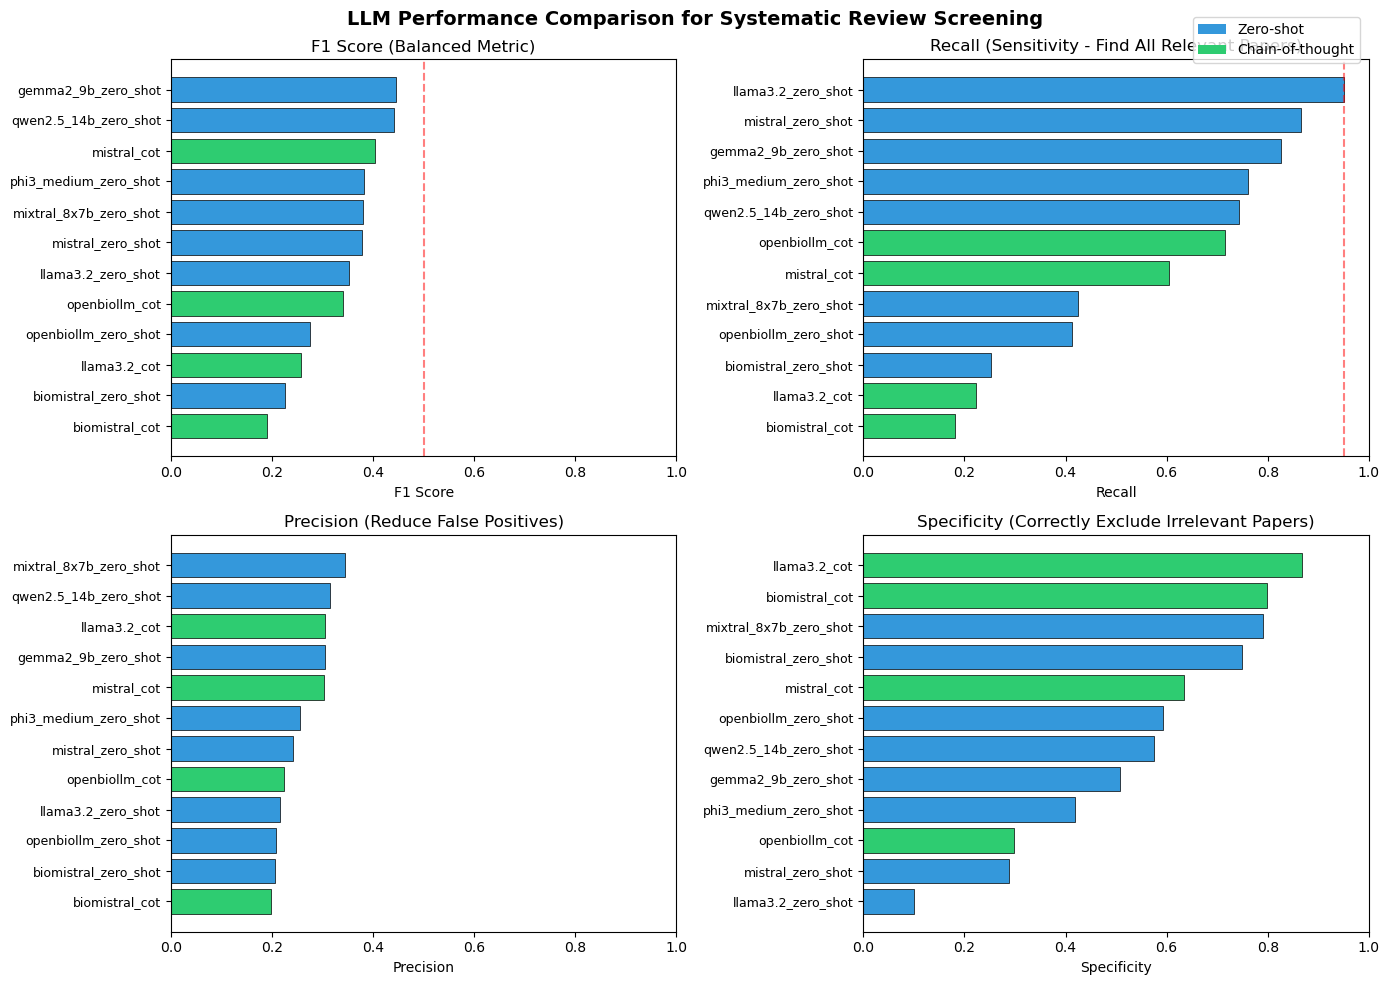


✓ Saved chart to model_comparison_chart.png

ZERO-SHOT vs CHAIN-OF-THOUGHT COMPARISON


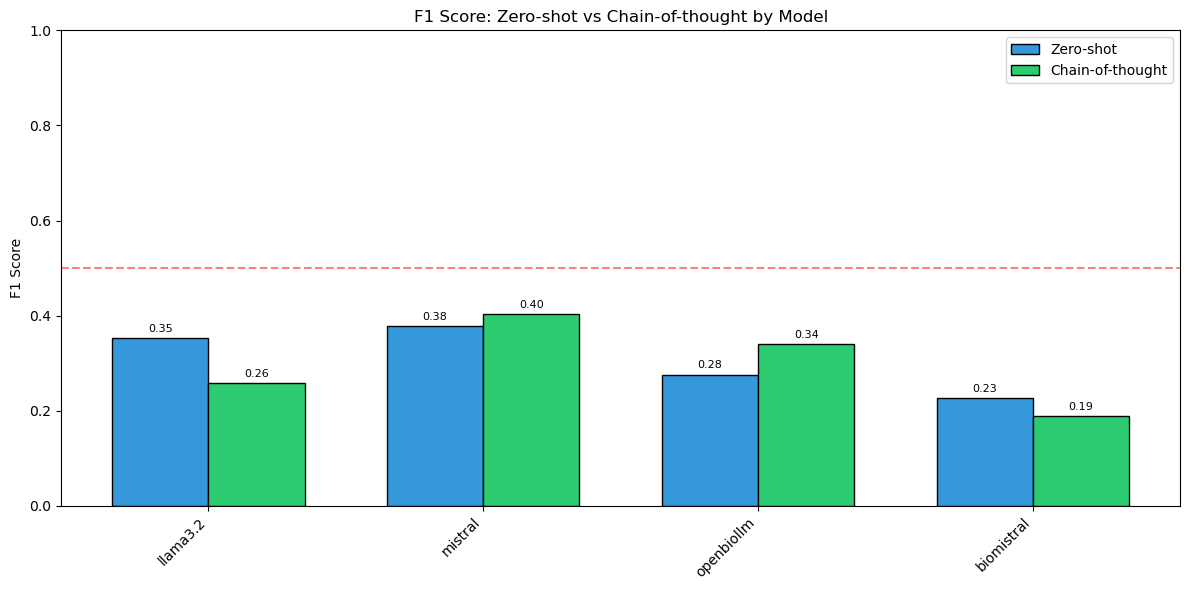

✓ Saved zero-shot vs CoT chart to zs_vs_cot_comparison.png


In [ ]:
# =============================================================================
# Compare All Results (loads from saved files) + Visualizations
# =============================================================================
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

print("=" * 80)
print("LOADING ALL RESULTS AND COMPARING")
print("=" * 80)

# Define all expected evaluations (13 models now including large models)
all_models = [
    # Large models (NEW)
    'deepseek_r1_32b', 'qwen2.5_32b', 'llama3.3_70b',
    # General-purpose models
    'llama3.2', 'llama3.1_8b', 'mistral', 'mixtral_8x7b', 'qwen2.5_14b', 
    'gemma2_9b', 'phi3_medium', 
    # Biomedical models
    'openbiollm', 'biomistral', 'meditron_7b'
]
prompt_types = ['zero_shot', 'cot']
expected = {f"{m}_{p}" for m in all_models for p in prompt_types}

# Load all results from files
comparison_rows = []
result_files = sorted(glob.glob(str(RESULTS_DIR / "eval_*.csv")))
completed = set()

for filepath in result_files:
    filename = Path(filepath).name
    # Parse filename: eval_{model}_{prompt_type}_{date}_{time}.csv
    # Example: eval_gemma2_9b_zero_shot_20260208_105918.csv
    match = re.match(r'eval_(.+)_(zero_shot|cot)_\d{8}_\d{6}\.csv', filename)
    if not match:
        continue
    
    model_name = match.group(1)
    prompt_type = match.group(2)
    
    completed.add(f"{model_name}_{prompt_type}")
    
    df = pd.read_csv(filepath)
    valid = df[df['prediction'] != -1]
    if len(valid) == 0:
        continue
    
    tn = ((valid['label'] == 0) & (valid['prediction'] == 0)).sum()
    tp = ((valid['label'] == 1) & (valid['prediction'] == 1)).sum()
    fn = ((valid['label'] == 1) & (valid['prediction'] == 0)).sum()
    fp = ((valid['label'] == 0) & (valid['prediction'] == 1)).sum()
    
    total_in_file = len(df)
    comparison_rows.append({
        'model': model_name,
        'prompt_type': prompt_type,
        'model_prompt': f"{model_name}_{prompt_type}",
        'total_samples': total_in_file,
        'valid_preds': len(valid),
        'parse_rate': len(valid) / total_in_file * 100 if total_in_file > 0 else 0,
        'accuracy': accuracy_score(valid['label'], valid['prediction']),
        'precision': precision_score(valid['label'], valid['prediction'], zero_division=0),
        'recall': recall_score(valid['label'], valid['prediction'], zero_division=0),
        'f1': f1_score(valid['label'], valid['prediction'], zero_division=0),
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
    })

comparison = pd.DataFrame(comparison_rows)
comparison = comparison.sort_values('f1', ascending=False)

# Progress summary
remaining = expected - completed
print(f"\n✓ Completed: {len(completed)}/20 evaluations")
print(f"✗ Remaining: {len(remaining)}/20 evaluations")
if remaining:
    print(f"  → {sorted(remaining)}")

print("\n" + "=" * 80)
print("IMPORTANT: Same validation dataset used for ALL models")
print("=" * 80)
print(f"• All models evaluated on the SAME {len(eval_data):,} Public Health samples")
print(f"• 'valid_preds' = responses successfully parsed as INCLUDE/EXCLUDE")
print(f"• 'parse_rate' = % of responses that could be parsed (lower = more invalid outputs)")
print(f"• Metrics computed only on valid predictions (invalid responses excluded)")

print("\n" + "=" * 80)
print("METRICS COMPARISON (sorted by F1)")
print("=" * 80)
display_cols = ['model_prompt', 'total_samples', 'valid_preds', 'parse_rate', 'accuracy', 'precision', 'recall', 'f1', 'specificity']
print(comparison[display_cols].to_string(index=False, float_format='{:.2f}'.format))

# Save comparison
comparison.to_csv(RESULTS_DIR / "model_comparison.csv", index=False)
print(f"\n✓ Saved comparison to model_comparison.csv")

# =============================================================================
# Visualization: Bar Charts
# =============================================================================
if len(comparison) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('LLM Performance Comparison for Systematic Review Screening', fontsize=14, fontweight='bold')
    
    # Sort by F1 for the plot
    plot_df = comparison.sort_values('f1', ascending=True)
    colors_sorted = ['#2ecc71' if pt == 'cot' else '#3498db' for pt in plot_df['prompt_type']]
    
    # 1. F1 Score
    ax1 = axes[0, 0]
    y_pos = np.arange(len(plot_df))
    ax1.barh(y_pos, plot_df['f1'], color=colors_sorted, edgecolor='black', linewidth=0.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(plot_df['model_prompt'], fontsize=9)
    ax1.set_xlabel('F1 Score')
    ax1.set_title('F1 Score (Balanced Metric)')
    ax1.set_xlim(0, 1)
    ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='0.5 threshold')
    
    # 2. Recall (Sensitivity)
    ax2 = axes[0, 1]
    plot_df_recall = comparison.sort_values('recall', ascending=True)
    colors_recall = ['#2ecc71' if pt == 'cot' else '#3498db' for pt in plot_df_recall['prompt_type']]
    ax2.barh(y_pos, plot_df_recall['recall'], color=colors_recall, edgecolor='black', linewidth=0.5)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(plot_df_recall['model_prompt'], fontsize=9)
    ax2.set_xlabel('Recall')
    ax2.set_title('Recall (Sensitivity - Find All Relevant Papers)')
    ax2.set_xlim(0, 1)
    ax2.axvline(x=0.95, color='red', linestyle='--', alpha=0.5, label='95% target')
    
    # 3. Precision
    ax3 = axes[1, 0]
    plot_df_prec = comparison.sort_values('precision', ascending=True)
    colors_prec = ['#2ecc71' if pt == 'cot' else '#3498db' for pt in plot_df_prec['prompt_type']]
    ax3.barh(y_pos, plot_df_prec['precision'], color=colors_prec, edgecolor='black', linewidth=0.5)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(plot_df_prec['model_prompt'], fontsize=9)
    ax3.set_xlabel('Precision')
    ax3.set_title('Precision (Reduce False Positives)')
    ax3.set_xlim(0, 1)
    
    # 4. Specificity
    ax4 = axes[1, 1]
    plot_df_spec = comparison.sort_values('specificity', ascending=True)
    colors_spec = ['#2ecc71' if pt == 'cot' else '#3498db' for pt in plot_df_spec['prompt_type']]
    ax4.barh(y_pos, plot_df_spec['specificity'], color=colors_spec, edgecolor='black', linewidth=0.5)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(plot_df_spec['model_prompt'], fontsize=9)
    ax4.set_xlabel('Specificity')
    ax4.set_title('Specificity (Correctly Exclude Irrelevant Papers)')
    ax4.set_xlim(0, 1)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3498db', label='Zero-shot'),
                       Patch(facecolor='#2ecc71', label='Chain-of-thought')]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'model_comparison_chart.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n✓ Saved chart to model_comparison_chart.png")
    
    # =============================================================================
    # Comparison: Zero-shot vs Chain-of-thought
    # =============================================================================
    print("\n" + "=" * 80)
    print("ZERO-SHOT vs CHAIN-OF-THOUGHT COMPARISON")
    print("=" * 80)
    
    # Find models with both prompt types
    models_with_both = []
    for m in all_models:
        if f"{m}_zero_shot" in completed and f"{m}_cot" in completed:
            models_with_both.append(m)
    
    if len(models_with_both) > 0:
        fig2, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(models_with_both))
        width = 0.35
        
        zs_f1 = [comparison[(comparison['model'] == m) & (comparison['prompt_type'] == 'zero_shot')]['f1'].values[0] 
                 for m in models_with_both]
        cot_f1 = [comparison[(comparison['model'] == m) & (comparison['prompt_type'] == 'cot')]['f1'].values[0] 
                  for m in models_with_both]
        
        bars1 = ax.bar(x - width/2, zs_f1, width, label='Zero-shot', color='#3498db', edgecolor='black')
        bars2 = ax.bar(x + width/2, cot_f1, width, label='Chain-of-thought', color='#2ecc71', edgecolor='black')
        
        ax.set_ylabel('F1 Score')
        ax.set_title('F1 Score: Zero-shot vs Chain-of-thought by Model')
        ax.set_xticks(x)
        ax.set_xticklabels(models_with_both, rotation=45, ha='right')
        ax.legend()
        ax.set_ylim(0, 1)
        ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
        
        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / 'zs_vs_cot_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✓ Saved zero-shot vs CoT chart to zs_vs_cot_comparison.png")
    else:
        print("Not enough models with both prompt types for comparison yet.")

In [ ]:
# =============================================================================
# Summary and Key Findings
# =============================================================================
print("\n" + "=" * 80)
print("EVALUATION SUMMARY")
print("=" * 80)

print(f"\n📊 DATASET")
print(f"   • Public Health subset: {len(eval_data):,} samples")
print(f"   • Ground truth available: {len(ground_truth):,} examples")
print(f"   • Included papers: {(eval_data['label']==1).sum():,} ({(eval_data['label']==1).mean()*100:.1f}%)")
print(f"   • Excluded papers: {(eval_data['label']==0).sum():,} ({(eval_data['label']==0).mean()*100:.1f}%)")

print(f"\n🤖 MODELS EVALUATED (13 models)")
print("   Large Models (3):    DeepSeek-R1 32B, Qwen 2.5 32B, Llama 3.3 70B")
print("   General-Purpose (7): Llama 3.2, Llama 3.1 8B, Mistral 7B, Mixtral 8x7B,")
print("                        Qwen 2.5 14B, Gemma 2 9B, Phi-3 Medium 14B")
print("   Biomedical (3):      OpenBioLLM-8B, BioMistral 7B, Meditron 7B")
print(f"\n   Prompt types: Zero-shot, Chain-of-thought")
print(f"   Temperature: 0.2 (deterministic)")
print(f"   Total experiments: 13 models × 2 prompts = 26 evaluations")

# Key findings from completed evaluations
if len(comparison) > 0:
    print(f"\n📈 KEY FINDINGS (from {len(comparison)} completed evaluations)")
    print("-" * 60)
    
    best_f1 = comparison.loc[comparison['f1'].idxmax()]
    best_recall = comparison.loc[comparison['recall'].idxmax()]
    best_precision = comparison.loc[comparison['precision'].idxmax()]
    
    print(f"   Best F1 Score:    {best_f1['model_prompt']:<25} F1={best_f1['f1']:.4f}")
    print(f"   Best Recall:      {best_recall['model_prompt']:<25} Recall={best_recall['recall']:.4f}")
    print(f"   Best Precision:   {best_precision['model_prompt']:<25} Precision={best_precision['precision']:.4f}")
    
    # Models with >95% recall (important for screening)
    high_recall = comparison[comparison['recall'] >= 0.95]
    if len(high_recall) > 0:
        print(f"\n   ✓ Models with ≥95% recall (suitable for screening):")
        for _, row in high_recall.iterrows():
            print(f"     - {row['model_prompt']}: Recall={row['recall']:.4f}, Precision={row['precision']:.4f}")
    else:
        print(f"\n   ⚠ No models achieved ≥95% recall yet")
    
    # Average metrics by prompt type
    print(f"\n   Average metrics by prompt type:")
    for pt in ['zero_shot', 'cot']:
        pt_data = comparison[comparison['prompt_type'] == pt]
        if len(pt_data) > 0:
            print(f"     {pt:12}: F1={pt_data['f1'].mean():.4f}, Recall={pt_data['recall'].mean():.4f}, Precision={pt_data['precision'].mean():.4f}")

print(f"\n📁 OUTPUTS")
print(f"   Results directory: {RESULTS_DIR}")
print(f"   • Individual results: eval_{{model}}_{{prompt}}_{{timestamp}}.csv")
print(f"   • Comparison table:   model_comparison.csv")
print(f"   • Charts:             model_comparison_chart.png, zs_vs_cot_comparison.png")

print(f"\n✓ All inference was LOCAL via Ollama - no data sent to external APIs.")
print("=" * 80)


EVALUATION SUMMARY

📊 DATASET
   • Public Health subset: 4,089 samples
   • Ground truth available: 41,692 examples
   • Included papers: 848 (20.7%)
   • Excluded papers: 3,241 (79.3%)

🤖 MODELS EVALUATED
   General-Purpose (7): Llama 3.2, Llama 3.1 8B, Mistral 7B, Mixtral 8x7B,
                        Qwen 2.5 14B, Gemma 2 9B, Phi-3 Medium 14B
   Biomedical (3):      OpenBioLLM-8B, BioMistral 7B, Meditron 7B

   Prompt types: Zero-shot, Chain-of-thought
   Total experiments: 10 models × 2 prompts = 20 evaluations

📈 KEY FINDINGS (from 12 completed evaluations)
------------------------------------------------------------
   Best F1 Score:    gemma2_9b_zero_shot       F1=0.4459
   Best Recall:      llama3.2_zero_shot        Recall=0.9505
   Best Precision:   mixtral_8x7b_zero_shot    Precision=0.3446

   ✓ Models with ≥95% recall (suitable for screening):
     - llama3.2_zero_shot: Recall=0.9505, Precision=0.2164

   Average metrics by prompt type:
     zero_shot   : F1=0.3605, Recall